### Try-it 9.2: Predicting Wages

This activity is meant to summarize your work with regularized regression models.  You will use your earlier work with data preparation and pipelines together with what you've learned with grid searches to determine an optimal model.  In addition to the prior strategies, this example is an excellent opportunity to utilize the `TransformedTargetRegressor` estimator in scikitlearn.

### The Data

This dataset is loaded from the openml resource library.  Originally from census data, the data contains wage and demographic information on 534 individuals. From the dataset documentation [here](https://www.openml.org/d/534)

```
The Current Population Survey (CPS) is used to supplement census information between census years. These data consist of a random sample of 534 persons from the CPS, with information on wages and other characteristics of the workers, including sex, number of years of education, years of work experience, occupational status, region of residence and union membership. 
```

In [1]:
from sklearn.datasets import fetch_openml

In [2]:
wages = fetch_openml(data_id=534, as_frame=True, parser="auto")

In [3]:
wages.frame.head()

,EDUCATION,SOUTH,SEX,EXPERIENCE,UNION,WAGE,AGE,RACE,OCCUPATION,SECTOR,MARR
0,8,no,female,21,not_member,5.10,35,Hispanic,Other,Manufacturing,Married
1,9,no,female,42,not_member,4.95,57,White,Other,Manufacturing,Married
2,12,no,male,1,not_member,6.67,19,White,Other,Manufacturing,Unmarried
3,12,no,male,4,not_member,4.00,22,White,Other,Other,Unmarried
4,12,no,male,17,not_member,7.50,35,White,Other,Other,Married


#### Task

Build regression models to predict `WAGE`.  Incorporate the categorical features and transform the target using a logarithm.  Build `Ridge` models and consider some different amounts of regularization.  

After fitting your model, interpret the model and try to understand what features led to higher wages.  Consider using `permutation_importance` that you encountered in module 8.  Discuss your findings in the class forum.

For an in depth example discussing the perils of interpreting the coefficients see the example in scikitlearn examples [here](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html).

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import warnings

In [14]:
#Step-1 review dataset 
wagesdf = wages.frame
#examine the dataset columns
print(wagesdf.info())
#get shape of dataset
print('Total number of rows=',wagesdf.shape[0])
print('Total number of columns=',wagesdf.shape[1])

#determine any null values
print(wagesdf.isnull().sum())

#get the unique value counts for category columns
catds = wagesdf.select_dtypes(include='category')
catds.info()
value_counts_report = {}
for column in catds.columns:
    value_counts_report[column] = catds[column].value_counts()
# Display the report
print("Value counts per Catgory Column: \n")
for column, value_counts in value_counts_report.items():
    print(f"{column}:\n{value_counts}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   EDUCATION   534 non-null    int64   
 1   SOUTH       534 non-null    category
 2   SEX         534 non-null    category
 3   EXPERIENCE  534 non-null    int64   
 4   UNION       534 non-null    category
 5   WAGE        534 non-null    float64 
 6   AGE         534 non-null    int64   
 7   RACE        534 non-null    category
 8   OCCUPATION  534 non-null    category
 9   SECTOR      534 non-null    category
 10  MARR        534 non-null    category
dtypes: category(7), float64(1), int64(3)
memory usage: 21.4 KB
None
Total number of rows= 534
Total number of columns= 11
EDUCATION     0
SOUTH         0
SEX           0
EXPERIENCE    0
UNION         0
WAGE          0
AGE           0
RACE          0
OCCUPATION    0
SECTOR        0
MARR          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>

In [26]:
#Step-2 create the dataset with encoded categorical variables
encoder = OneHotEncoder(handle_unknown='ignore', drop = 'if_binary', 
                        feature_name_combiner='concat')
encoded_df = pd.DataFrame(
    encoder.fit_transform(wagesdf.select_dtypes(include='category')).toarray(), 
    columns=encoder.get_feature_names_out(['SOUTH','SEX','UNION','RACE','OCCUPATION','SECTOR','MARR']))

#concat encoded dataframe to original dataframe
wages_all=pd.concat([wagesdf,encoded_df], axis=1)
#drop categorical columns as they have been encoded
wages_final = wages_all.select_dtypes(exclude='category')
print('Shape of dataset including categorical + encoded columns=',wages_all.shape)
print('Shape of dataset excluding categorical with encoded columns=',wages_final.shape)

Shape of dataset including categorical + encoded columns= (534, 27)
Shape of dataset excluding categorical with encoded columns= (534, 20)


In [30]:
#Step-3 create independant and dependant variables and the train and test dataset
X = wages_final.drop('WAGE', axis=1)
y = np.log(wagesdf['WAGE'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state = 42)
print('Total number of rows in training set=',X_train.shape[0])
print('Total number of rows in test set=',X_test.shape[0])
print('Total number of columns=',X_train.shape[1])

Total number of rows in training set= 373
Total number of rows in test set= 161
Total number of columns= 19


In [32]:
#Step-4 create the piepline and the model
ridge_params_dict = {"ridge__alpha":[0.01, 0.1,1.0,10.0,100.0, 1000.0]}
ridge_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge())])
ridge_grid = GridSearchCV(estimator=ridge_pipe, param_grid=ridge_params_dict)
ridge_grid.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('ridge', Ridge())]),
             param_grid={'ridge__alpha': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]})

In [35]:
#Step5 determine best alpha, model and coeffs associated with the best alpha
best_alpha = ridge_grid.best_params_
best_estimator = ridge_grid.best_estimator_
best_model = best_estimator.named_steps['ridge']
feature_names = X_train.columns
coefs = best_model.coef_
print("Best Alpha value=",best_alpha)
print("Best Model = ",best_model )
print("Coeffecients of best model (",best_alpha, ")=")
#pd.DataFrame([coefs.T], columns = feature_names, index = ['model'])

coef_dict = {}
for coef, feat in zip(coefs,feature_names):
    coef_dict[feat] = coef
coef_df = pd.DataFrame(list(coef_dict.items()), columns=["feature", "coeff"])

print(coef_df.reindex(coef_df['coeff'].abs().sort_values(ascending=False).index))

#determne training and valiation MSE for the best alpha

ridge_train_mse = mean_squared_error(y_train, ridge_grid.predict(X_train))
ridge_test_mse = mean_squared_error(y_test, ridge_grid.predict(X_test))

print("MSE for Training data on Ridge model = ",round(ridge_train_mse,4))
print("MSE for Test data on Ridge model = ",round(ridge_test_mse,4))

Best Alpha value= {'ridge__alpha': 100.0}
Best Model =  Ridge(alpha=100.0)
Coeffecients of best model ( {'ridge__alpha': 100.0} )=
                    feature     coeff
0                 EDUCATION  0.099732
5          UNION_not_member -0.080013
4                  SEX_male  0.079558
12  OCCUPATION_Professional  0.063735
2                       AGE  0.062081
14       OCCUPATION_Service -0.060747
10    OCCUPATION_Management  0.055176
1                EXPERIENCE  0.038522
3                 SOUTH_yes -0.034460
18           MARR_Unmarried -0.025488
13         OCCUPATION_Sales -0.024399
11         OCCUPATION_Other -0.024037
17             SECTOR_Other -0.023830
16     SECTOR_Manufacturing  0.019461
8                RACE_White  0.018925
7                RACE_Other -0.013219
6             RACE_Hispanic -0.012701
15      SECTOR_Construction  0.011939
9       OCCUPATION_Clerical -0.010406
MSE for Training data on Ridge model =  0.1795
MSE for Test data on Ridge model =  0.1895


In [47]:
#Step-6 Determine which feature is most important

# Initialize a list of results
results = []
# Iterate through each predictor
for predictor in X_test:
    
    # Create a copy of X_test
    X_test_copy = X_test.copy()
    
    # Scramble the values of the given predictor
    X_test_copy[predictor] = X_test[predictor].sample(frac=1).values
    
    # Calculate the new RMSE
    new_rmse = mean_squared_error(ridge_grid.predict(X_test_copy), y_test,
                                  squared = False)
    
    # Append the increase in MSE to the list of results 
    results.append({'pred': predictor,
                    'score': new_rmse - ridge_test_mse })
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)
resultsdf

,pred,score
0,EDUCATION,0.302642
4,SEX_male,0.274221
12,OCCUPATION_Professional,0.267353
14,OCCUPATION_Service,0.260284
10,OCCUPATION_Management,0.256708
5,UNION_not_member,0.256016
18,MARR_Unmarried,0.250185
11,OCCUPATION_Other,0.249841
13,OCCUPATION_Sales,0.248691
3,SOUTH_yes,0.247846


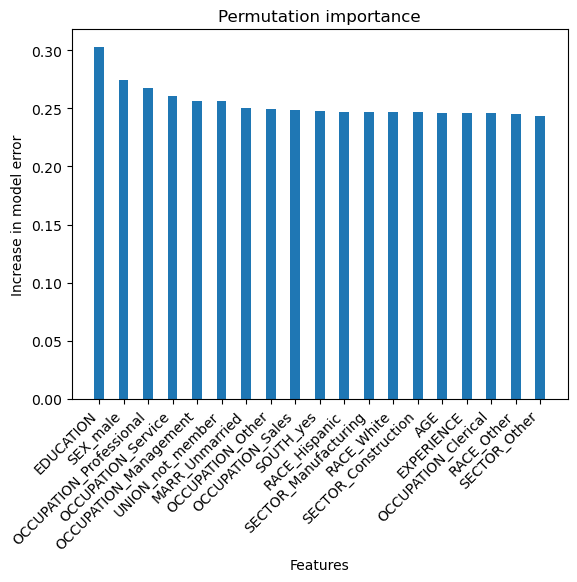

In [55]:
#Step 7 Visualize permuation importance 

plt.bar(resultsdf['pred'], resultsdf['score'],  width = 0.4)
 
plt.xlabel("Features")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Increase in model error")
plt.title("Permutation importance")
plt.show()